<a href="https://colab.research.google.com/github/koreahong/statistic_for_machine_learning-randomforest-logisticregression/blob/main/%ED%87%B4%EC%82%AC%EC%9E%A5%EB%B6%84%EB%A5%98_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B3%BC_%ED%86%B5%EA%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [285]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score,classification_report
import matplotlib.pyplot as plt

In [241]:
hrattr_data = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Statistics-for-Machine-Learning/master/Chapter04/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [242]:
hrattr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [27]:
hrattr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   object
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   object
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   object
 14  JobLevel                

- null 값이 없는 보기드문 데이터이다. 널값처리는 패스!
- 범주형 변수가 있기때문에 get_dummies를 활용해 변수처리가 필요
- 결과 값인 "Attrition" 을 0과 1로 변화해야함

In [243]:
#Attrition 값변경 yes : 1, no : 0
hrattr_data['Attrition'] = hrattr_data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

## 해당기업의 근무환경을 알아보자

In [20]:
hrattr_data['Attrition'].value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

- 라벨값 분포를 보면 1이 매우 적음을 알 수 있다. 퇴사한 데이터이기 때문, 추후 모델링때 class_weight 부여 필요

In [21]:
#근무환경 만족도
hrattr_data['EnvironmentSatisfaction'].value_counts()

#1이 안좋다는 가정하에 대체로 만족할만한 환경이라는 답변이 우세

3    453
4    446
2    287
1    284
Name: EnvironmentSatisfaction, dtype: int64

In [23]:
#초과근무 
hrattr_data['OverTime'].value_counts()

#거의 두배이상이 초과근무를 안했다. 다소 초과근무 압박이 없는? 회사인거 같다

No     1054
Yes     416
Name: OverTime, dtype: int64

In [ ]:
#연령

print("평균연령", round(hrattr_data['Age'].mean()))
hrattr_data['Age'].value_counts().hist()

#우리나라 2018년 사내평균연령이 42세인 것을 감안하면 해당기업은 젊은층에 속함

In [34]:
#부서

hrattr_data['Department'].value_counts()
#데이터가 어느정도 필터링이 됬겠지만, r&d인원이 상당히 많음

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

In [35]:
pd.crosstab(hrattr_data['Department'],hrattr_data['Attrition'])

Attrition,0,1
Department,,
Human Resources,51,12
Research & Development,828,133
Sales,354,92


In [41]:
#근속연수

hrattr_data['YearsAtCompany'].mean()

#우리나라 2020년 기준 6.8년이다. 해당기업은 근속연수가 비교적 우수함

7.0081632653061225

In [42]:
hrattr_data['Gender'].value_counts()


Male      882
Female    588
Name: Gender, dtype: int64

In [43]:
#워라벨

hrattr_data['WorkLifeBalance'].value_counts()

#전반적으로 워라벨이 만족한다는 대답이다. 

3    893
2    344
4    153
1     80
Name: WorkLifeBalance, dtype: int64

In [44]:
hrattr_data['NumCompaniesWorked'].value_counts()

#첫 회사 경험 후 해당기업으로 이직한 숫자가 압도적으로 많다.

1    521
0    197
3    159
2    146
4    139
7     74
6     70
5     63
9     52
8     49
Name: NumCompaniesWorked, dtype: int64

평균한달수입 : 6503


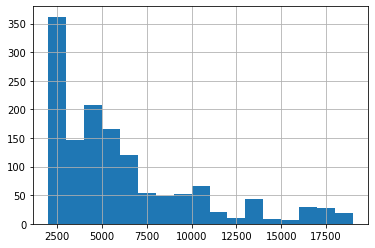

In [53]:
print("평균한달수입 :" , round(hrattr_data['MonthlyIncome'].mean()))
hrattr_data['MonthlyIncome'].hist(bins = list(range(2000,20000,1000)))

#미국평균연봉이 2020년 기준 75000달러이고 달로 따지면 6200정도이다. 
#평균 6500이지만 6000이하의 달러를 받는 직원이 과반이다.

- 워라벨 우수, 장기근속 우수, 해당기업으로 이직 다수, 연봉은 다소 낮음
- 결과적으로 근무환경이 잘 갖춰져 있는 회사이고 워라벨을 중시하는 사람들이 다니는 회사라고 판단할 수 있음

#데이터 전처리

In [244]:
#employeeNumber는 단순 구분 숫자 임으로 삭제
hrattr_data.drop('EmployeeNumber', axis=1, inplace=True)

##Dtype은 int이나 내용이 범주형인 피쳐 확인

- Dtype은 int이나 그 형태가 범주형을 띄는 피쳐들이 있다. 해당피쳐들을 추출하여 범주형피쳐로 전환

In [245]:
#Dtype이 int 피쳐 추출
continuous_columns = set(hrattr_data.columns)- set(hrattr_data.select_dtypes(include=[np.object]).columns)

In [246]:
#object로 변환
for i in continuous_columns:
  if len(hrattr_data[i].value_counts().index.unique()) <= 10:
    hrattr_data[i] = hrattr_data[i].astype('object')

## 이상치 확인

In [247]:
for column in hrattr_data.select_dtypes(include=[np.int]).columns:
  q1, q3 = np.percentile(hrattr_data[column].values,[25,75])
  iqr = q3-q1
  lower_bound = q1 - (iqr * 1.5)
  upper_bound = q3 + (iqr * 1.5)

  outlier_index = hrattr_data[(hrattr_data[column] > upper_bound) | (hrattr_data[column] < lower_bound)].index
  hrattr_data.drop(outlier_index, axis=0, inplace= True)
  hrattr_data.reset_index(drop=True, inplace=True)

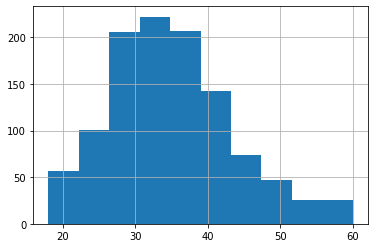

In [42]:
hrattr_data['Age'].hist()

#이상치 제거 후 예쁜 정규분포의 형태를 띈다

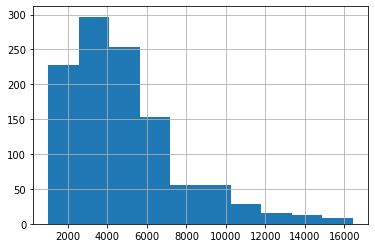

In [43]:
hrattr_data['MonthlyIncome'].hist()

#아직 한달수입은 정규분포 형태를 띄지 않는다 -> 정규화 작업 필요

##라벨 분리

In [248]:
label = hrattr_data['Attrition']
label = label.astype('int')
hrattr_data.drop('Attrition', axis=1, inplace=True)

##원 핫 인코딩

In [249]:
hrattr_data_object = pd.get_dummies(hrattr_data[hrattr_data.select_dtypes(include=[np.object]).columns])

##정규화

In [250]:
scaler = SS()

data_scaled = scaler.fit_transform(hrattr_data[hrattr_data.select_dtypes(include=[np.int]).columns])

In [251]:
data_scaled = pd.DataFrame(data_scaled,columns=hrattr_data.select_dtypes(include=[np.int]).columns)

#데이터 합치기

In [252]:
hrattr_data_new = pd.concat([data_scaled,hrattr_data_object], axis=1)

##데이터분리 
- 트레이닝
- 테스트

In [253]:
x_train, x_test, y_train, y_test = train_test_split(hrattr_data_new, label, test_size = 0.2, 
                                                    random_state=28, stratify=label)

##모델생성

In [265]:
rf_fit  = rf(n_estimators=5000,criterion="gini",max_depth=5,min_samples_split=2,bootstrap=True,
                                max_features='auto',random_state=42,min_samples_leaf=1,class_weight = {0:0.3,1:0.7})
rf_fit.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.3, 1: 0.7}, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=5000, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [266]:
print ("\nRandom Forest - Train Confusion Matrix\n\n",pd.crosstab(y_train,rf_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Train accuracy",round(accuracy_score(y_train,rf_fit.predict(x_train)),3))
print ("\nRandom Forest  - Train Classification Report\n",classification_report(y_train,rf_fit.predict(x_train)))

print ("\n\nRandom Forest - Test Confusion Matrix\n\n",pd.crosstab(y_test,rf_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Test accuracy",round(accuracy_score(y_test,rf_fit.predict(x_test)),3))
print ("\nRandom Forest - Test Classification Report\n",classification_report(y_test,rf_fit.predict(x_test)))


Random Forest - Train Confusion Matrix

 Predicted    0   1
Actuall           
0          719  10
1           75  81

Random Forest - Train accuracy 0.904

Random Forest  - Train Classification Report
               precision    recall  f1-score   support

           0       0.91      0.99      0.94       729
           1       0.89      0.52      0.66       156

    accuracy                           0.90       885
   macro avg       0.90      0.75      0.80       885
weighted avg       0.90      0.90      0.89       885



Random Forest - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          177   6
1           29  10

Random Forest - Test accuracy 0.842

Random Forest - Test Classification Report
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       183
           1       0.62      0.26      0.36        39

    accuracy                           0.84       222
   macro avg       0.74      0.61      0.64       22

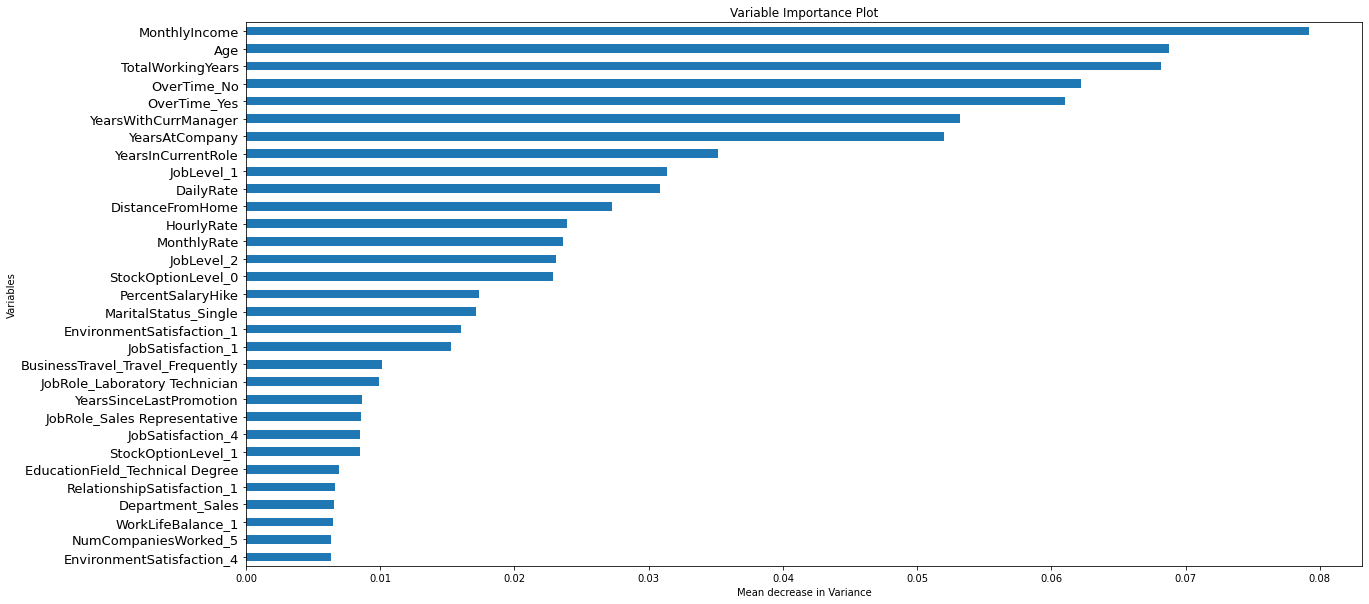

In [286]:
# Plot of Variable importance by mean decrease in gini
model_ranks = pd.Series(rf_fit.feature_importances_,index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:31].sort_values(ascending=True,inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
_ = ax.set_title("Variable Importance Plot")
_ = ax.set_xlabel('Mean decrease in Variance')
_ = ax.set_yticklabels(top_features.index, fontsize=13)


In [282]:
lr_clf = lr(penalty ='l2', C = 1)
lr_clf.fit(x_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [283]:
print ("\nLogisticRegression - Train Confusion Matrix\n\n",pd.crosstab(y_train,lr_clf.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nLogisticRegression - Train accuracy",round(accuracy_score(y_train,lr_clf.predict(x_train)),3))
print ("\nLogisticRegression - Train Classification Report\n",classification_report(y_train,lr_clf.predict(x_train)))

print ("\n\nLogisticRegression - Test Confusion Matrix\n\n",pd.crosstab(y_test,lr_clf.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nLogisticRegression - Test accuracy",round(accuracy_score(y_test,lr_clf.predict(x_test)),3))
print ("\nLogisticRegression - Test Classification Report\n",classification_report(y_test,lr_clf.predict(x_test)))


LogisticRegression - Train Confusion Matrix

 Predicted    0   1
Actuall           
0          713  16
1           63  93

LogisticRegression - Train accuracy 0.911

LogisticRegression - Train Classification Report
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       729
           1       0.85      0.60      0.70       156

    accuracy                           0.91       885
   macro avg       0.89      0.79      0.82       885
weighted avg       0.91      0.91      0.90       885



LogisticRegression - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          180   3
1           19  20

LogisticRegression - Test accuracy 0.901

LogisticRegression - Test Classification Report
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       183
           1       0.87      0.51      0.65        39

    accuracy                           0.90       222
   macro avg       0.89

In [298]:
model_coef = pd.Series(lr_clf.coef_[0], hrattr_data_new.columns).sort_values(ascending=False)

OverTime_Yes                        1.085743
BusinessTravel_Travel_Frequently    0.908302
TrainingTimesLastYear_0             0.906118
NumCompaniesWorked_5                0.865651
WorkLifeBalance_1                   0.782667
dtype: float64

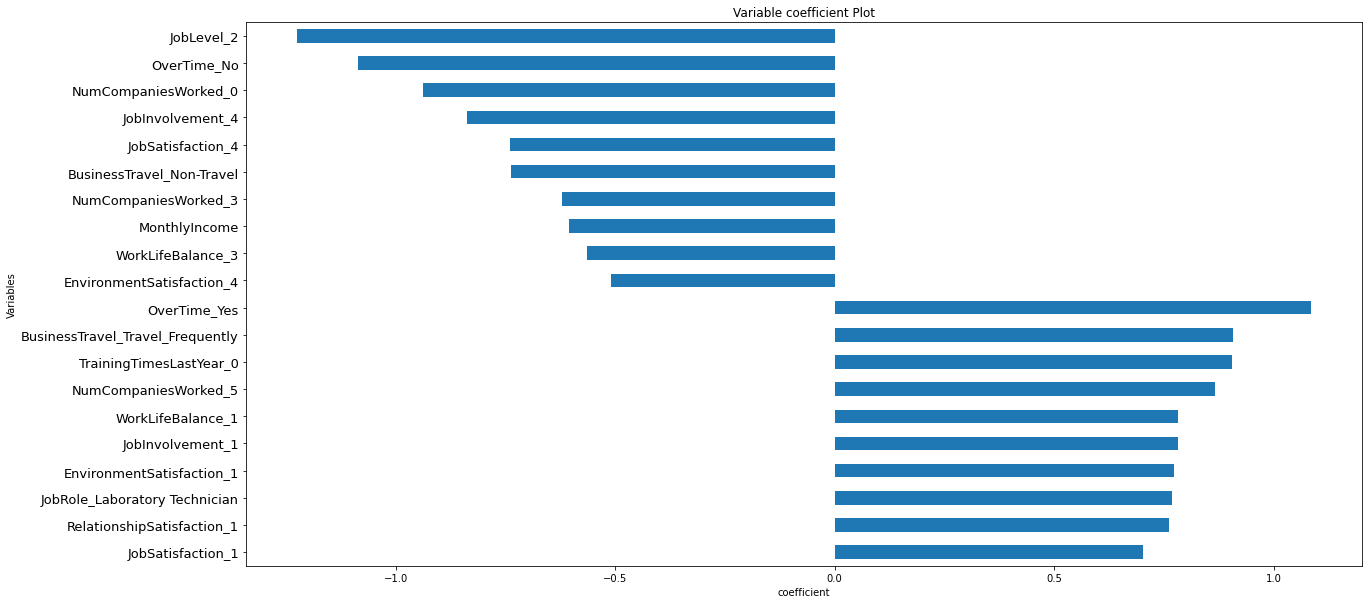

In [305]:
model_ranks = pd.Series(model_coef,model_coef.index, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = pd.concat([model_ranks.iloc[:10].sort_values(ascending=True,inplace=False), model_ranks.iloc[-10:]])
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
_ = ax.set_title("Variable coefficient Plot")
_ = ax.set_xlabel('coefficient')
_ = ax.set_yticklabels(top_features.index, fontsize=13)

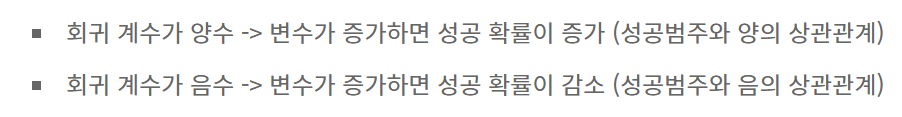

그리드서치 알고리즘을 통해 파라미터 튜닝이 필요하지만 전반적으로 로지스틱 회귀의 성능이 더 좋게 나왔다.